In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import utils
from Sampling import Sampling
from VAE import VAE
from CAN import CAN

In [2]:
vae_epoch = 10000
can_epoch = 10000
batch_size = 64
latent_dim = 10
beta_eeg = 5.0

In [3]:
data_root = "/home/zainkhan/bci-representation-learning"
eeg_train, eeg_test, pupil_train, pupil_test = utils.read_single_trial_datasets(data_root)

In [4]:
# Load all encoders/decoders
vae = VAE(beta=beta_eeg, latent_dim=latent_dim)
vae.encoder = keras.models.load_model("vae_encoder_z/vae_encoder")
vae.decoder = keras.models.load_model("vae_decoder_z/vae_decoder")

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)    
plt.rc('ytick', labelsize=MEDIUM_SIZE)    
plt.rc('legend', fontsize=MEDIUM_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [8, 8]

In [6]:
def image_split(orig, rec):
    orig, rec = np.squeeze(orig), np.squeeze(rec)
    orig = np.mean(orig, axis=0)
    rec = np.mean(rec, axis=0)
    
    orig_targ = orig[:len(orig)//2]
    rec_targ = rec[:len(rec)//2]
    orig_dist = orig[len(orig)//2:]
    rec_dist = rec[len(rec)//2:]
    
    return (orig_targ, orig_dist, rec_targ, rec_dist)

In [7]:
def plot_eeg_reconstruction(orig, rec, save=False, filename=''):
    plt.rcParams['figure.figsize'] = [12, 10]
    orig_targ, orig_dist, rec_targ, rec_dist = image_split(orig, rec)
    
    mse = lambda x,y : np.mean(np.square(x - y))
    err_t = np.sqrt(mse(orig_targ, rec_targ))
    err_d = np.sqrt(mse(orig_dist, rec_dist))
    corr_t = pearsonr(orig_targ, rec_targ)[0]
    corr_d = pearsonr(orig_dist, rec_dist)[0]
    
    x = np.linspace(-500, 1000, num=orig.shape[1]//2)
    plt.subplot(2, 1, 1)
    plt.plot(x, orig_targ, label='Original')
    plt.plot(x, rec_targ, label='Reconstruction')
    plt.plot([], [], ' ', label=f'RMSE: {err_t:.2f}')
    plt.plot([], [], ' ', label=f'Corr.: {corr_t:.2f}')
    plt.legend(loc='upper left', frameon=True)
    plt.title('Channel Averaged Original vs Reconstruction', fontsize=16)
    plt.ylabel('Targets (Avg Z)')

    plt.subplot(2, 1, 2)
    plt.plot(x, orig_dist, label='Original')
    plt.plot(x, rec_dist, label='Reconstruction')  
    plt.plot([], [], ' ', label=f'RMSE: {err_d:.2f}')
    plt.plot([], [], ' ', label=f'Corr.: {corr_d:.2f}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Distractors (Avg Z)')
    plt.legend(loc='upper left', frameon=True)
    fig = plt.gcf()
    plt.show()

    if save:
        fig.savefig(filename + '.png')

In [8]:
_, _, eeg_encode = vae.encoder.predict(eeg_test)
ee_rec = vae.decoder.predict(eeg_encode)

In [60]:
i = 500
fn = 'ee' + str(i)
plot_eeg_reconstruction(eeg_test[i], ee_rec[i], save=True, filename=fn)

TypeError: object of type 'numpy.float32' has no len()

In [26]:
_, _, eeg_encode_train = vae.encoder.predict(eeg_train)
ee_rec_train = vae.decoder.predict(eeg_encode_train)

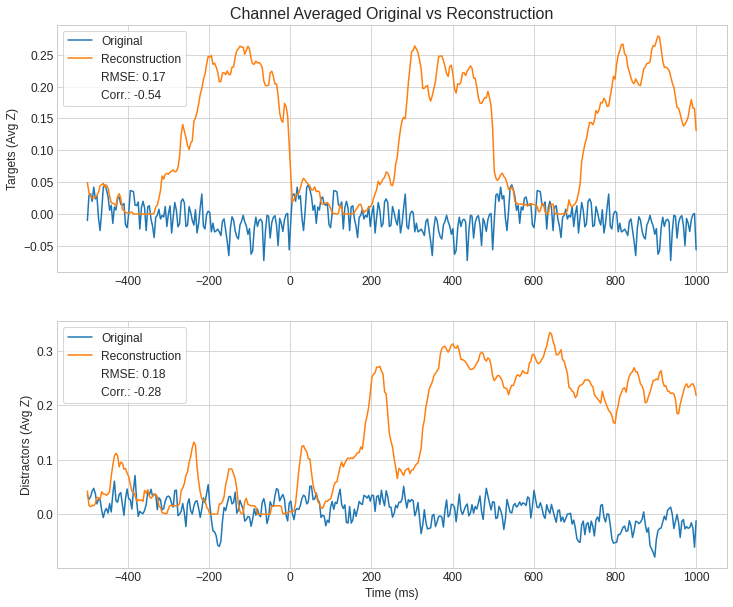

In [63]:
i = 602
fn = 'ee' + str(i)
plot_eeg_reconstruction(eeg_train[i], ee_rec_train[i], save=False, filename=fn)

In [9]:
def plot_subj_cond(X, vals, ylabel, legend, filename='', width=0.8):
    plt.rcParams['figure.figsize'] = [15, 8]
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align='edge', label=legend[i])   
    plt.xticks(_X, X)
    plt.xlabel('Subject (#)')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left', frameon=True)
    fig = plt.gcf()
    plt.show()

    if filename != '':
        fig.savefig(filename + '.png')

In [41]:
eeg_free, eeg_eye, pupil_free, pupil_eye = utils.read_dataset_by_condition(data_root)

eeg_free_rec = []
eeg_eye_rec = []
for i in range(len(eeg_free)):
    _, _, encoded = vae.encoder.predict(eeg_free[i])
    eeg_free_rec.append(vae.decoder.predict(encoded))
    
    _, _, encoded = vae.encoder.predict(eeg_eye[i])
    eeg_eye_rec.append(vae.decoder.predict(encoded))

In [65]:
simplify = lambda a: np.mean(np.squeeze(a), axis=0)
for i in range(len(eeg_free)):
    eeg_free[i] = simplify(eeg_free[i])
    eeg_eye[i] = simplify(eeg_eye[i])
    eeg_free_rec[i] = simplify(eeg_free_rec[i])
    eeg_eye_rec[i] = simplify(eeg_eye_rec[i])

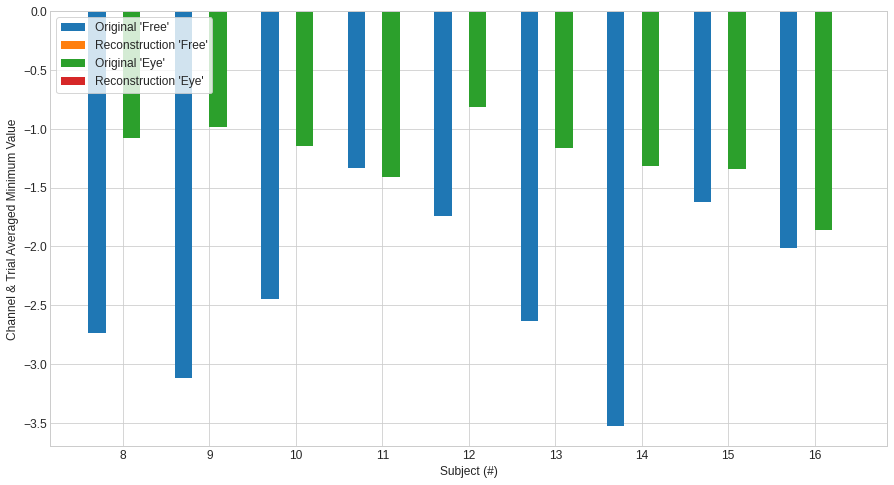

In [30]:
f = lambda x: np.min(x)
ef = [f(i) for i in eeg_free]
efr = [f(i) for i in eeg_free_rec]
ee = [f(i) for i in eeg_eye]
eer = [f(i) for i in eeg_eye_rec]

legend = ['Original \'Free\'', 'Reconstruction \'Free\'', 'Original \'Eye\'', 'Reconstruction \'Eye\'']
ylabel = 'Channel & Trial Averaged Minimum Value'
filename = 'min'
plot_subj_cond(range(8,17), [ef, efr, ee, eer], ylabel, legend, filename)

In [66]:
eeg_free_targ = [i[:len(i)//2] for i in eeg_free]
eeg_free_dist = [i[len(i)//2:] for i in eeg_free]
eeg_eye_targ = [i[:len(i)//2] for i in eeg_eye]
eeg_eye_dist = [i[len(i)//2:] for i in eeg_eye]

eeg_free_rec_targ = [i[:len(i)//2] for i in eeg_free_rec]
eeg_free_rec_dist = [i[len(i)//2:] for i in eeg_free_rec]
eeg_eye_rec_targ = [i[:len(i)//2] for i in eeg_eye_rec]
eeg_eye_rec_dist = [i[len(i)//2:] for i in eeg_eye_rec]

In [67]:
eeg_free[0].shape
eeg_free_targ[0].shape

(32, 768)

In [68]:
simplify = lambda a: np.mean(np.squeeze(a), axis=0)
for i in range(len(eeg_free_targ)):
    eeg_free_targ[i] = simplify(eeg_free_targ[i])
    eeg_free_dist[i] = simplify(eeg_free_dist[i])
    eeg_eye_targ[i] = simplify(eeg_eye_targ[i])
    eeg_eye_dist[i] = simplify(eeg_eye_dist[i])
    
    eeg_free_rec_targ[i] = simplify(eeg_free_rec_targ[i])
    eeg_free_rec_dist[i] = simplify(eeg_free_rec_dist[i])
    eeg_eye_rec_targ[i] = simplify(eeg_eye_rec_targ[i])
    eeg_eye_rec_dist[i] = simplify(eeg_eye_rec_dist[i])

In [69]:
eeg_free_targ[0].shape

(768,)

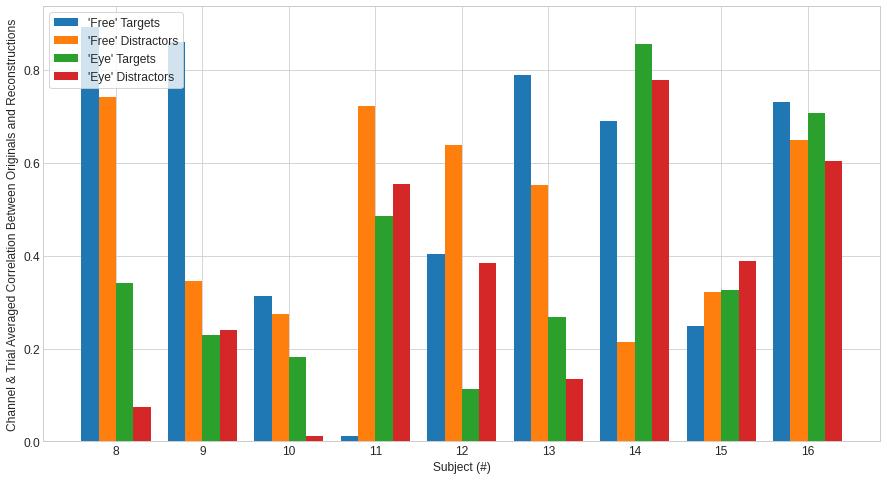

In [70]:
g = lambda x, y: np.abs(pearsonr(x, y)[0])
eft = [g(eeg_free_targ[i], eeg_free_rec_targ[i]) for i in range(len(eeg_free_targ))]
efd = [g(eeg_free_dist[i], eeg_free_rec_dist[i]) for i in range(len(eeg_free_dist))]
eet = [g(eeg_eye_targ[i], eeg_eye_rec_targ[i]) for i in range(len(eeg_eye_targ))]
eed = [g(eeg_eye_dist[i], eeg_eye_rec_targ[i]) for i in range(len(eeg_eye_dist))]

legend = ['\'Free\' Targets', '\'Free\' Distractors', '\'Eye\' Targets', '\'Eye\' Distractors']
ylabel = 'Channel & Trial Averaged Correlation Between Originals and Reconstructions'
filename = 'correl'
plot_subj_cond(range(8,17), [eft, efd, eet, eed], ylabel, legend, filename)

In [39]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=50, init='pca', random_state=0)
X_tsne = tsne.fit_transform(eeg_encode)
y = range(len(eeg_encode))

def plot_embedding(X, colormetric, title=None, filename=None):
    plt.rcParams['figure.figsize'] = [12, 10]
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    #for i in range(X.shape[0]):
        #plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(colormetric[i]))
    im = ax.scatter(X[:, 0], X[:, 1], c=colormetric, cmap='viridis')
    if title is not None:
        plt.title(title)
    plt.colorbar(im)
    fig = plt.gcf()
    plt.show()
    if filename is not None:
        fig.savefig(filename + '.png')

In [11]:
simplify = lambda a: np.mean(np.squeeze(a), axis=0)
eeg_test_red = []
ee_rec_red = []
for i in range(len(eeg_test)):
    eeg_test_red.append(simplify(eeg_test[i]))
    ee_rec_red.append(simplify(ee_rec[i]))

(768,)

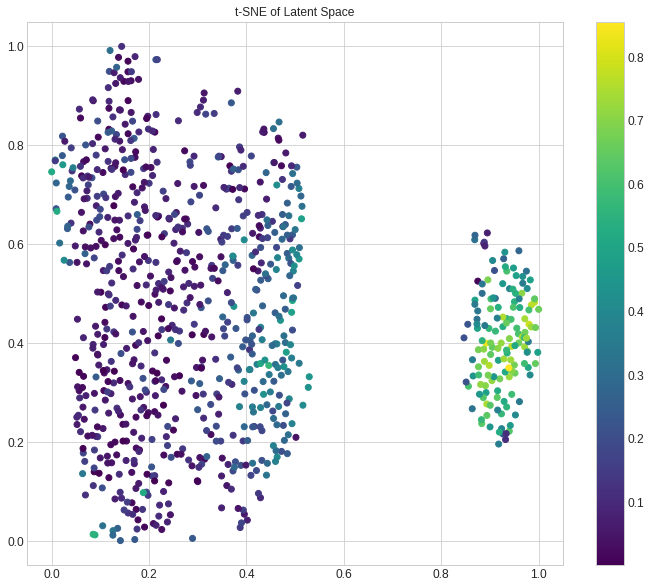

In [40]:
g = lambda x, y: np.abs(pearsonr(x, y)[0])
corr = [g(eeg_test_red[i], ee_rec_red[i]) for i in range(len(eeg_test))]
plot_embedding(X_tsne, corr, 't-SNE of Latent Space', 'tsne')

In [110]:
print(corr[740])

0.3687862965632363


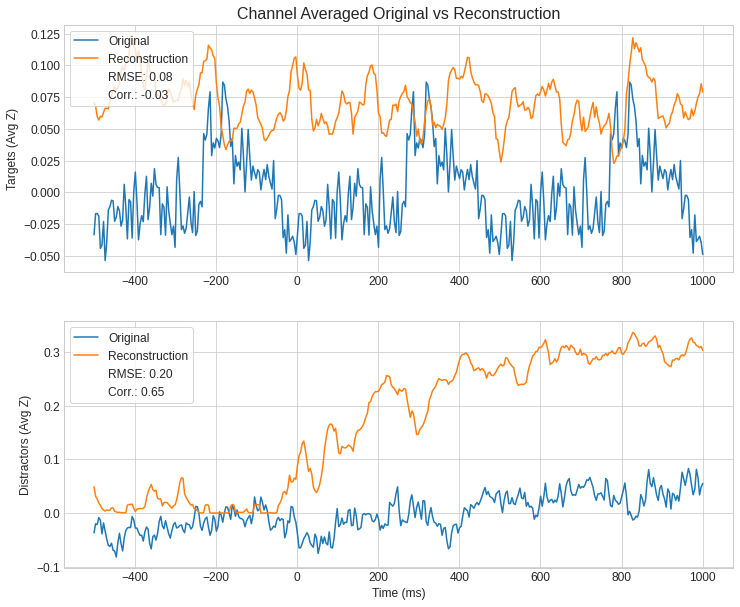

In [111]:
i = 505
fn = 'ee' + str(i)
plot_eeg_reconstruction(eeg_test[i], ee_rec[i], save=False, filename=fn)

In [80]:
eeg_test.shape

(865, 64, 768, 1)

In [24]:
noisy = []
good = []
for i in range(X_tsne.shape[0]):
    if X_tsne[i,0] > 0.6:
        noisy.append(i)
    else:
        good.append(i)
print(len(noisy))
print(len(good))

384
481


In [69]:
X_tsne_train = tsne.fit_transform(eeg_encode_train)
simplify = lambda a: np.mean(np.squeeze(a), axis=0)
eeg_train_red = []
ee_train_rec = []
for i in range(len(eeg_train)):
    eeg_train_red.append(simplify(eeg_train[i]))
    ee_train_rec.append(simplify(ee_rec_train[i]))

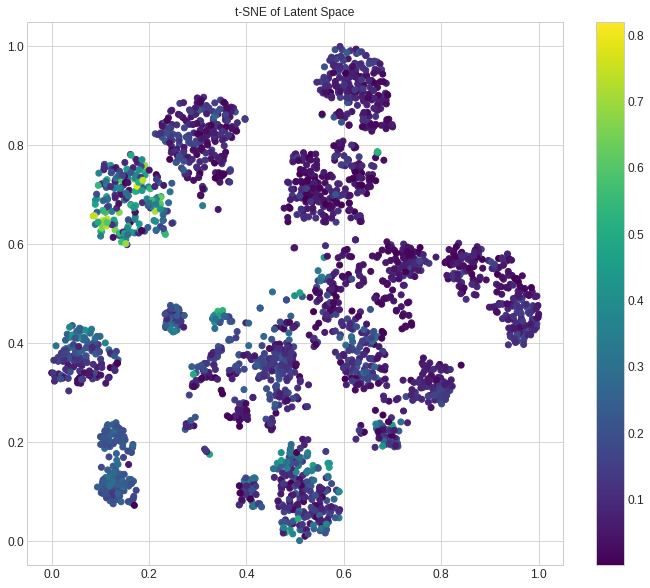

In [70]:
g = lambda x, y: np.abs(pearsonr(x, y)[0])
corr_train = [g(eeg_train_red[i], ee_train_rec[i]) for i in range(len(eeg_train))]
plot_embedding(X_tsne_train, corr_train, 't-SNE of Latent Space', 'tsne')

In [45]:
eeg = np.concatenate((eeg_train, eeg_test), axis=0)

In [47]:
_, _, eeg_encode_all = vae.encoder.predict(eeg)
ee_rec_all = vae.decoder.predict(eeg_encode_all)

In [50]:
X_tsne_all = tsne.fit_transform(eeg_encode_all)
simplify = lambda a: np.mean(np.squeeze(a), axis=0)
eeg_red = []
ee_rec = []
for i in range(len(eeg)):
    eeg_red.append(simplify(eeg[i]))
    ee_rec.append(simplify(ee_rec_all[i]))

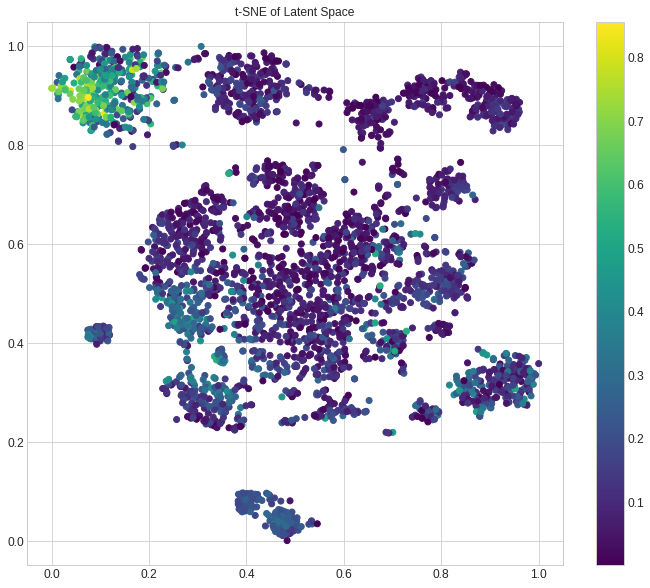

In [51]:
g = lambda x, y: np.abs(pearsonr(x, y)[0])
corr_all = [g(eeg_red[i], ee_rec[i]) for i in range(len(eeg))]
plot_embedding(X_tsne_all, corr_all, 't-SNE of Latent Space', 'tsne')

In [57]:
i = 0
X = X_tsne_all
x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)
print(X[2323+noisy[i],0], X[2323+noisy[i], 1])

0.30701223 0.51971555


In [73]:
minmax = lambda x: (x-np.min(x,0)) / (np.max(x,0)-np.min(x,0))
X_tsne_train = minmax(X_tsne_train)
noisy_train = []
for i in range(X_tsne_train.shape[0]):
    if X_tsne_train[i,0] < 0.25 and X_tsne_train[i, 1] > 0.6 and X_tsne_train[i, 1] < 0.8:
        noisy_train.append(i)

In [75]:
np.save('noisy_train.npy', noisy_train)

In [76]:
np.save('noisy_test.npy', noisy)

384

In [5]:
eeg_train.shape

(2323, 64, 768, 1)

In [6]:
eeg_train, eeg_test = utils.remove_noisy_trials(eeg_train, eeg_test)

IndexError: index 599 is out of bounds for axis 0 with size 64